# Holdout validation on Section 1 numerical experiment

3/2/21



In [1]:
%load_ext autoreload
%autoreload 2

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex
from osd.utilities import progress
import cvxpy as cvx

In [4]:
from admm_helpers import markov_process_simulator, run_admm

# Convex example, $K=3$

In [86]:
# np.random.seed(43)
t = np.linspace(0, 250, 1000)
signal1 = 0.5 * (np.sin(2 * np.pi * t * 5 / (500.)) + np.cos(2 * np.pi * t * 2.5 / (500.) - 50))
signal2 = markov_process_simulator([[0.9, 0.1], [0.1, 0.9]], T=len(t), plot=False)
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

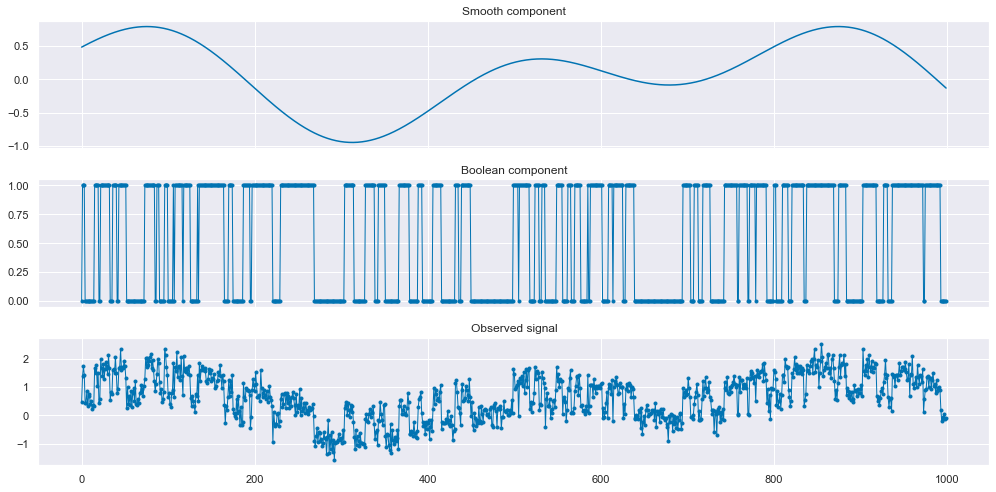

In [87]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(signal1)
ax[1].set_title('Boolean component')
ax[1].plot(signal2, linewidth=1, marker='.')
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

# Non-convex ADMM with holdout validation

Take 5 random holdout samples and solve over 10 possible values of theta. Calculate holdout mean square error (HSME) for each (sample, rho) entry.

Based on discussion with Dr. Boyd on 3/1/21, it was determined that the holdout procedure is somewhat more complicated  in this example than is immediately obvious. Because the Boolean constraint is seperable, we cannot make any reasonable estimate of that component at the houldout indices. So, when reconstructing the signal, we choose 0 or 1 for the Boolean component based on whichever minimizes the residual at that index location. After implementing this improvement, the holdout validation procedure works as expected.

In [146]:
ti = time()
num_samples = 5
thetas = np.logspace(-1, 9, 31)
out = pd.DataFrame(columns=['sample', 'theta', 'hmse'])
ix = 1
sample = np.arange(len(y))
for sn in range(num_samples):
    use_ix = np.random.choice(sample, size=800, replace=False)
    use_ix = np.array([True if s in use_ix else False for s in sample])
    for th in thetas:
        switch_at = 16
        run_noncvx = run_admm(y, num_iter=switch_at+100, rho=2.2908676527677736, theta=th, switch_at=switch_at,
                              boolean_truth=signal2, use_ix=use_ix, verbose=False)
        estimate0 = run_noncvx['x1'] + run_noncvx['x2']
        estimate1 = run_noncvx['x1'] + run_noncvx['x2'] + 1
        error0 = (y - estimate0)[~use_ix]
        error1 = (y - estimate1)[~use_ix]
        errors = np.array([error0, error1])
        choices = np.argmin(np.abs(errors), axis=0)
        M = np.array([choices == 0, choices == 1], dtype=int)
        error = np.diag(errors.T @ M)
        hmse = np.average(np.power(error, 2))
        out.loc[ix] = [sn, th, hmse]
        ix += 1
tf = time()
print('{:.2f} minutes'.format((tf - ti) / 60))

10.41 minutes


464158.8833612772


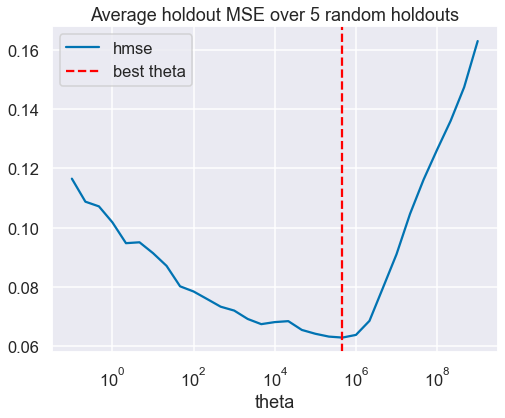

In [170]:
summary = out.groupby('theta').aggregate(np.average)
best_theta = summary.index[np.argmin(summary['hmse'])]
print(best_theta)
summary.plot(y='hmse', figsize=(8, 6))
plt.xscale('log')
plt.axvline(best_theta, color='red', ls='--', label='best theta')
plt.legend()
plt.title('Average holdout MSE over 5 random holdouts')
plt.show()

In [155]:
summary.iloc[summary['hmse'].argmin()]

sample    2.000000
hmse      0.062836
Name: 464158.8833612772, dtype: float64

In [224]:
switch_at = 24
run_noncvx = run_admm(y, num_iter=switch_at+100, rho=2.2908676527677736, theta=464158.8833612772, switch_at=switch_at,
                      boolean_truth=signal2, use_ix=use_ix)
m1 = 'obj val:  {:.2f}'.format(run_noncvx['best_obj'])
m2 = 'num errs: {}'.format(run_noncvx['boolean_errors'][run_noncvx['it']])
m3 = 'best it:  {}'.format(run_noncvx['it'])
print('\n'.join([m1, m2, m3]))

[============================================================] 100.0% ...5.85 sec
obj val:  125.13
num errs: 81
best it:  33


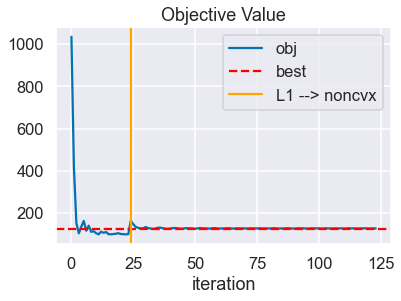

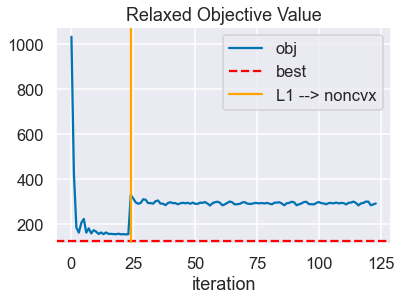

In [225]:
plt.plot(run_noncvx['obj_vals'], label='obj')
plt.axhline(run_noncvx['best_obj'], ls='--', color='red', label='best')
plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration');
# plt.ylim(260, 400);
plt.show()
plt.plot(run_noncvx['relaxed_obj_vals'], label='obj')
plt.axhline(run_noncvx['best_obj'], ls='--', color='red', label='best')
plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
plt.legend()
plt.title('Relaxed Objective Value')
plt.xlabel('iteration');
# plt.ylim(260, 400);

best:  81 errors


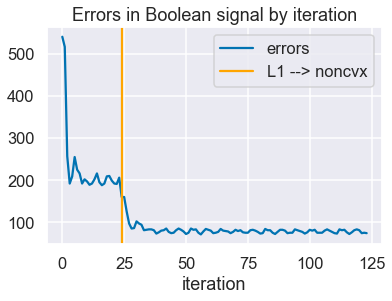

In [226]:
print('best: ', run_noncvx['boolean_errors'][run_noncvx['it']], 'errors')
plt.plot(run_noncvx['boolean_errors'], label='errors')
plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
plt.legend()
plt.title('Errors in Boolean signal by iteration')
plt.xlabel('iteration');

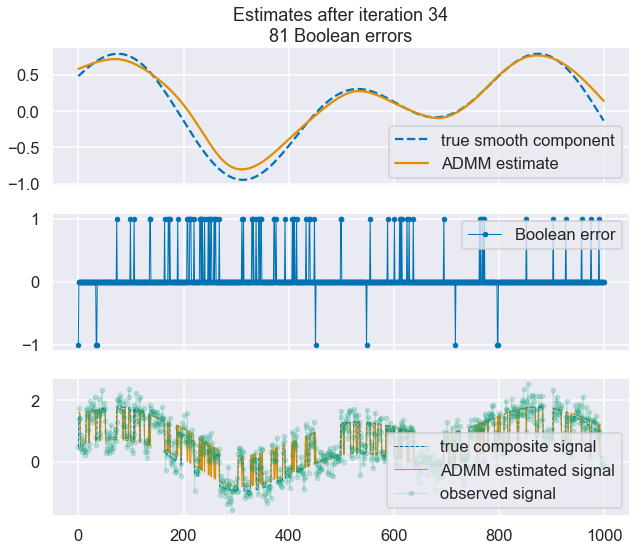

In [227]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5), sharex=True)
ax[0].plot(signal1, label='true smooth component', ls='--')
ax[0].plot(run_noncvx['x2'], label='ADMM estimate ')
ax[1].plot(signal2 - run_noncvx['x3'], label='Boolean error', linewidth=1, marker='.')
ax[2].plot(signal1 + signal2, label='true composite signal', ls='--', linewidth=1)
ax[2].plot(run_noncvx['x2'] + run_noncvx['x3'], label='ADMM estimated signal', linewidth=1);
ax[2].plot(y, label='observed signal', linewidth=1, marker='.', alpha=0.2);
for a in ax:
    a.legend()
ax[0].set_title('Estimates after iteration {}\n{} Boolean errors'.format(run_noncvx['it'] + 1,
                                                                        run_noncvx['boolean_errors'][run_noncvx['it']]));
plt.tight_layout()

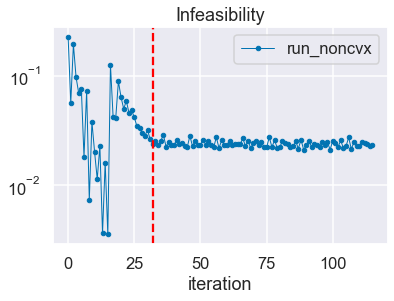

In [223]:
plt.plot(run_noncvx['residuals'], label='run_noncvx', linewidth=1, marker='.')
plt.axvline(run_noncvx['it'], ls='--', color='red')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

In [69]:
# for ix, estimate in enumerate(run_noncvx['boolean_estimates']):
#     plt.figure(figsize=(8,6))
#     plt.plot(signal2, ls='--', linewidth=1)
#     plt.plot(estimate, linewidth=1)
#     er = run_noncvx['boolean_errors'][ix]
#     plt.title('{:.2f}% incorrect'.format(100 * er / len(signal2)))
#     plt.savefig('save_figs/boolean_estimate_it_{:03}'.format(ix))
#     plt.close(plt.gcf());

### Note! This table was generated from a different randomized data instance and results may not exacly match new instances

In [14]:
results_table = pd.read_csv('noncvx-admm-results-table_20210224.csv', index_col=0)

# rhos = np.logspace(-1, 1, 101)
# switch_points = np.round(np.logspace(-1, 6, 8, base=2))
# results_table = pd.DataFrame(columns=['sp', 'rho', 'min_obj'])
# # objective_values = []
# # objective_trends = []
# ix = 0
# total = len(rhos) * len(switch_points)
# ti = time()
# for sp in switch_points:
#     for r in rhos:
#         tn = time()
#         progress(ix, total, '{:.2f} minutes'.format((tn - ti) / 60))
#         run_noncvx = run_admm(y, num_iter=int(sp+100), rho=r, theta=1e6, switch_at=sp, verbose=False)
# #         objective_values.append(run_noncvx['best_obj'])
# #         objective_trends.append(run_noncvx['obj_vals'])
#         results_table.loc[ix] = [sp, r, run_noncvx['best_obj']]
#         ix += 1
# tn = time()
# progress(ix, total, '{:.2f} minutes'.format((tn - ti) / 60))
# results_table.to_csv('noncvx-admm-results-table_20210224.csv')

In [15]:
results_table

,sp,rho,min_obj
0,0.0,0.100000,102.694803
1,0.0,0.104713,102.362801
2,0.0,0.109648,103.075644
3,0.0,0.114815,103.014690
4,0.0,0.120226,103.240813
...,...,...,...
803,64.0,8.317638,136.431569
804,64.0,8.709636,136.883313
805,64.0,9.120108,139.349829
806,64.0,9.549926,141.128660


In [16]:
best_run = results_table.loc[np.argmin(results_table['min_obj'])]
best_run

sp         16.000000
rho         2.290868
min_obj    65.379606
Name: 573, dtype: float64

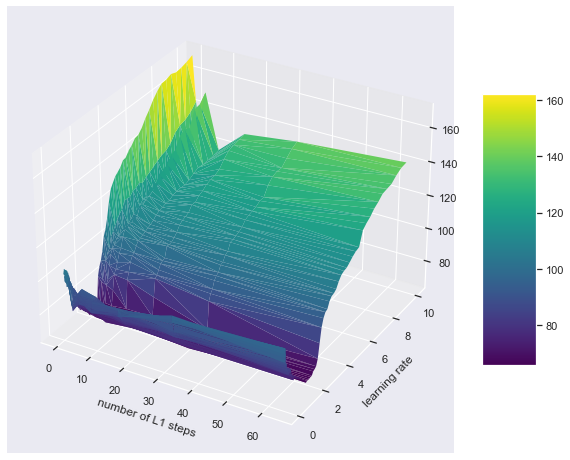

In [17]:
# Make the plot
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(results_table['sp'], results_table['rho'], results_table['min_obj'], cmap=plt.cm.viridis,
                     linewidth=0.001)

fig.colorbar( surf, shrink=0.5, aspect=5)
plt.xlabel('number of L1 steps')
plt.ylabel('learning rate')
plt.show()

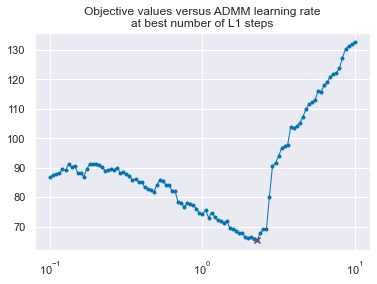

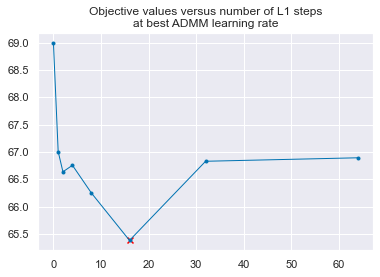

In [18]:
best_steps = results_table[np.isclose(results_table['sp'], best_run['sp'])]
best_rhos = results_table[np.isclose(results_table['rho'], best_run['rho'])]
plt.figure()
plt.title('Objective values versus ADMM learning rate\nat best number of L1 steps')
plt.plot(best_steps['rho'], best_steps['min_obj'], marker='.', linewidth=1)
plt.scatter(best_run['rho'], best_run['min_obj'], marker='x', color='red')
plt.xscale('log')
plt.show()
plt.figure()
plt.title('Objective values versus number of L1 steps\nat best ADMM learning rate')
plt.plot(best_rhos['sp'], best_rhos['min_obj'], marker='.', linewidth=1)
plt.scatter(best_run['sp'], best_run['min_obj'], marker='x', color='red')
# plt.xscale('log')
plt.show()

In [ ]:
thetas = np.logspace()